In [3]:
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 
import os

import jp_mpl as jplot

import pickle
import matplotlib.ticker as ticker
import rat_misc, jp_analysis
from scipy import optimize


In [4]:
import matplotlib
matplotlib.rcParams.update({'font.size':12,
                            'legend.fontsize':'large',
                            'xtick.labelsize': 'large',
                           'ytick.labelsize':'large',
                           'axes.labelsize':'large'})

In [5]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))

In [6]:
# Inform me of all the hits that we have for each wavelength
all_runs = pickle.load(open('/home/jpyanez/snoplus/data/snoplus_data/laserball_runs/pmt_position_fit/all_runs_info.pckl'))

In [7]:
all_runs.keys()

['pmt_toa',
 'pmt_toa_err',
 'pmt_toa_fit',
 'lb_position',
 'lb_t0',
 'lb_wavelength',
 'lb_run',
 'pmt_toa_std',
 'pmt_nhit']

In [8]:
fits_dir = '/home/jpyanez/snoplus/data/snoplus_data/laserball_runs/pmt_position_fit'
fits_list = [x for x in os.listdir(fits_dir) if 'PMT_fits' in x]

In [9]:
dist_ax = np.arange(0, 10000, 10)
chi2_ax = np.arange(0, 10000, 10)


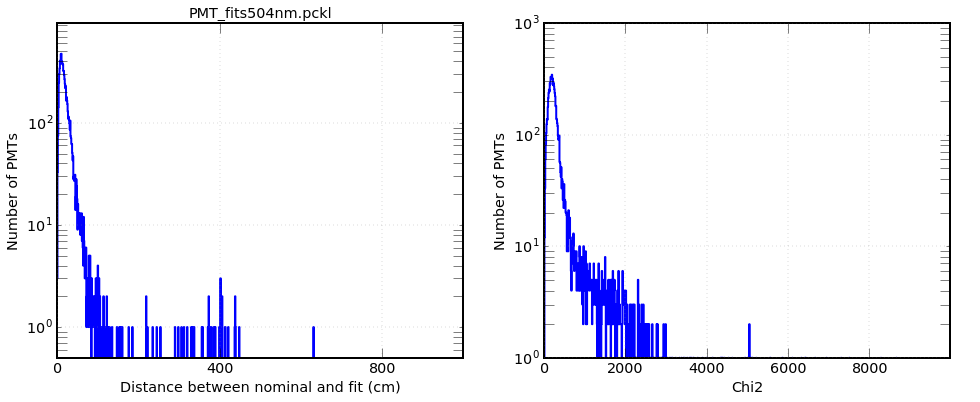

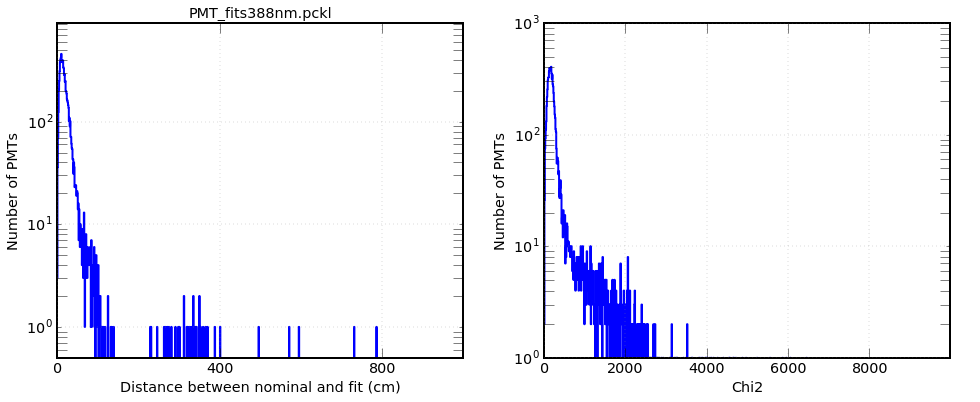

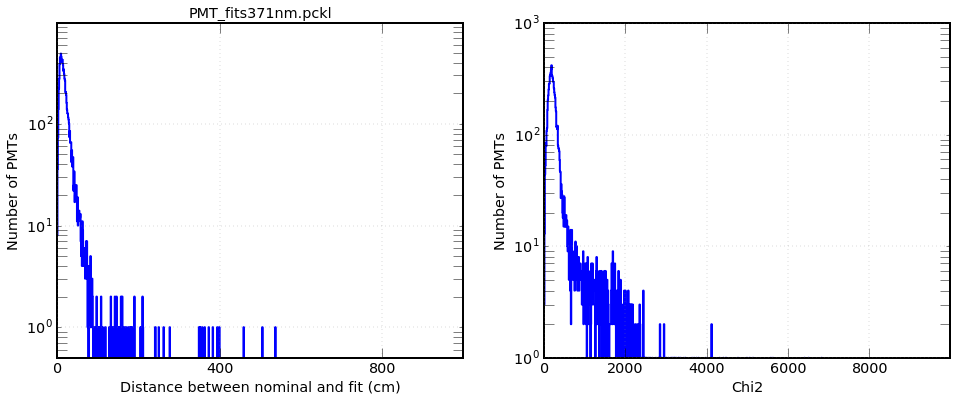

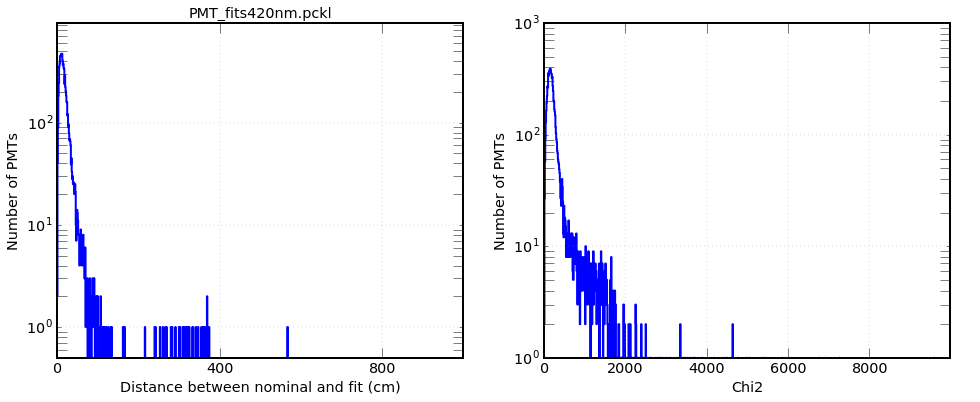

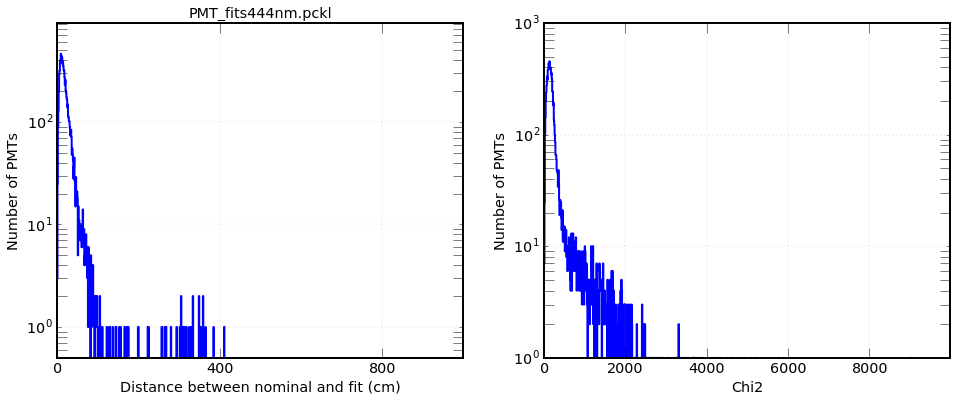

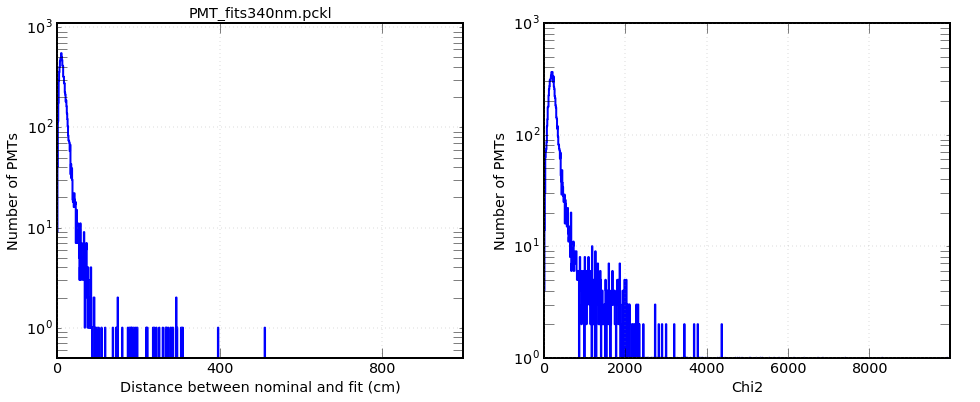

In [10]:
for one_fit in fits_list:
    fit = pickle.load(open(os.path.join(fits_dir, one_fit)))
    b, x = np.histogram(fit['distance'][fit['distance']>0], dist_ax)
        
    if b.sum()==0:
        continue

    b2, x2 = np.histogram(fit['chi2'][fit['distance']>0], chi2_ax)        
        
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(121)
    plt.title(one_fit)
    jplot.unfilledBar(x/10.,b)
    plt.yscale('log')
    plt.xlabel('Distance between nominal and fit (cm)')
    plt.ylabel('Number of PMTs')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(400.))
    plt.ylim([0.5, b.max()*2])
    
    ax2 = fig.add_subplot(122)
    jplot.unfilledBar(x2,b2)
    plt.yscale('log')
    plt.xlabel('Chi2')
    plt.ylabel('Number of PMTs')
        

In [11]:
wavelengths = np.unique(all_runs['lb_wavelength'])
for wl in wavelengths:
    print wl, np.sum(all_runs['pmt_nhit'][wl==all_runs['lb_wavelength'],:])


337.0 137423175.0
340.0 430402962.0
369.0 38552507.0
371.0 497419384.0
388.0 421364302.0
419.0 664255297.0
420.0 479605548.0
444.0 446259734.0
502.0 565161039.0
504.0 31756220.0


In [12]:
wavelength = 340
outdir='/home/jpyanez/snoplus/analysis/pmt_positions/fit_summary'
outdir += '/wl' + "%i" % wavelength
filename = 'PMT_fits' + "%i" % wavelength + 'nm.pckl'
wlstr = "%i" % wavelength + "nm"
fit_file = '/home/jpyanez/snoplus/data/snoplus_data/laserball_runs/pmt_position_fit/' + filename

In [13]:
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    os.mkdir(os.path.join(outdir, 'pmt_t0'))

In [14]:
outfile = os.path.join(outdir, filename.rstrip('.pckl'))

2394.5559082


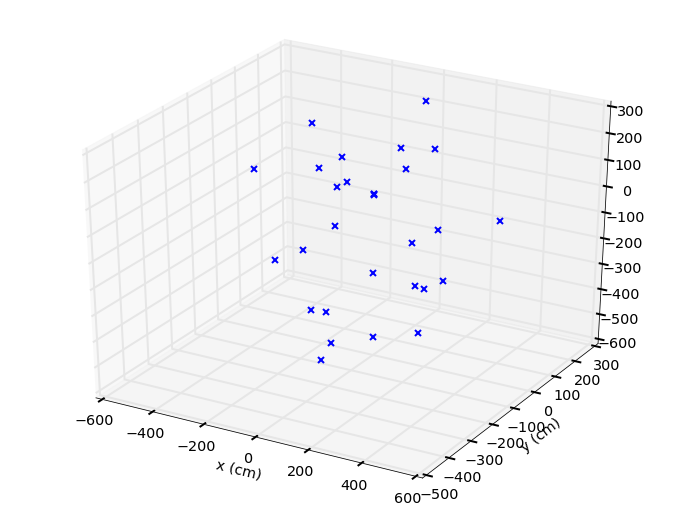

In [18]:
# Plot the position of the LB runs at this wavelength
from mpl_toolkits.mplot3d import Axes3D

runs_xyz = all_runs['lb_position'][(wavelength==all_runs['lb_wavelength'])*(all_runs['lb_position'][:,2] < 3500.),:]
runs_nhit = np.sum(all_runs['pmt_nhit'][wavelength==all_runs['lb_wavelength'],:],axis=1)
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(runs_xyz[:,0]/10., runs_xyz[:,1]/10., runs_xyz[:,2]/10., 'x')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
#plt.zlabel('z (mm)')
fig.savefig(outfile + "_Runs.png", dpi=200)
print runs_xyz[:,2].max()


In [19]:
fit = pickle.load(open(fit_file))

In [20]:
radius_tol = 200.
psup_r = 8406.
dist_tol = 300. # In mm
angle_tol = np.deg2rad(1.7) # In degrees

In [21]:
v1 = (fit['xyz'].T/np.linalg.norm(fit['xyz'],axis=1)).T
v2 = (pmt_info['xyz'].T/np.linalg.norm(pmt_info['xyz'],axis=1)).T
fit['angle'] = np.zeros(v1.shape[0])
for i in range(len(fit['angle'])):
    fit['angle'][i] = np.arccos(np.dot(v1[i,:], v2[i,:]))

/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [22]:
fit['radius'] = np.linalg.norm(fit['xyz'], axis=1)
fit['costheta'] = fit['xyz'][:,2]/fit['radius']
fit['phi']      = np.arctan2(fit['xyz'][:,1], 
                      fit['xyz'][:,0])

/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


In [23]:
valid_radius = np.abs(fit['radius']-psup_r) < radius_tol
non_neck = pmt_info['costheta']<0.85
valid_fits = (fit['distance']>0.)*(pmt_info['type']==1)*non_neck*(fit['chi2']>0)
print 'PMTs that have a valid radius', np.sum(valid_radius), '/', np.sum(valid_fits)
print np.sum(~valid_radius*valid_fits)

PMTs that have a valid radius 7056 / 8094
1442


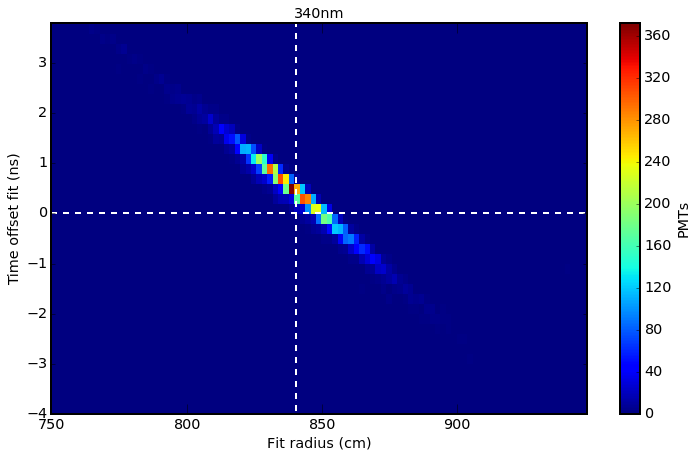

In [24]:
dist_ax = np.arange(750, 950, 2)
t0_ax = np.arange(-4, 4, 0.2)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)

b,x,y = np.histogram2d(fit['radius'][valid_fits]/10.,
                       fit['t0'][valid_fits],
                       [dist_ax, t0_ax])
plt.pcolor(dist_ax, t0_ax, b.T)
plt.ylabel('Time offset fit (ns)')
plt.xlabel('Fit radius (cm)')
plt.xlim(dist_ax.min(), dist_ax.max())
plt.ylim(t0_ax.min(), t0_ax.max())
plt.axhline(y=0, xmin =0., xmax = dist_ax.max(), color = 'white', linestyle='--')
plt.axvline(x=psup_r/10., ymin =t0_ax.min(), ymax = t0_ax.max(), color = 'white', linestyle='--')
cb = plt.colorbar()
cb.ax.set_ylabel('PMTs')
plt.title(wlstr)
fig.savefig(outfile + "_FitRadiusVsTime.png", dpi=200)
fig.savefig(outfile + "_FitRadiusVsTime.pdf")

In [25]:
matplotlib.cm.jet.set_bad(color='white')

In [26]:
def plotCCC(pmt_values = None, pmt_bool = None, invalid_value = np.nan,
            **args):
    max_crates   = 18
    max_cards    = 15
    max_channels = 31
    

    if pmt_bool != None:
        pmt_bool = np.array(pmt_bool, dtype=bool)
        print 'Applying conditions'
        pmt_values[~pmt_bool] = invalid_value
    
    # Card/channel histogram
    card_ax = np.arange(0, max_cards+1, 1)
    chan_ax = np.arange(0, max_channels+1, 1)
    
    fig = plt.figure(figsize=(24, 7))
    ax = []
    
    # Creating histograms
    histograms = []
    for crate in range(max_crates+2):
        histograms.append(np.zeros([len(card_ax), len(chan_ax)]))
    
    # Filling histograms
    #print type(pmt_info['ccc'])
    for i in range(len(pmt_values)):
        #print pmt_info['ccc'][i,0], [pmt_info['ccc'][i,1], pmt_info['ccc'][i,2]]
        histograms[pmt_info['ccc'][i,0]][pmt_info['ccc'][i,1], pmt_info['ccc'][i,2]] = pmt_values[i]
    
    #print histograms[0]
        
    for crate in range(max_crates+2):
        ax.append(fig.add_subplot(2,10, crate+1))
        ax[-1].set_title("%i" % crate)
        ax[-1].set_xticks([])
        ax[-1].set_yticks([])
        if crate == max_crates+1:
            continue
        #plt.pcolor( card_ax, chan_ax, histograms[crate].T,
        #            **args)
        plt.imshow(histograms[crate].T, aspect='auto', interpolation='none',
                    **args)
        plt.xlim(0, card_ax[-1])
        plt.ylim(0, chan_ax[-1])

    plt.colorbar()
    return fig
        
        # Remove ticks and all
        

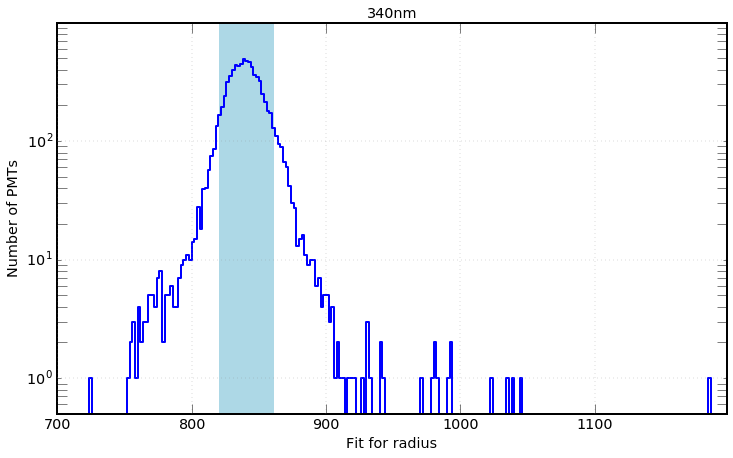

In [27]:
dist_ax = np.arange(700, 1200, 2)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)


b, x = np.histogram(fit['radius'][valid_fits]/10., dist_ax)

jplot.unfilledBar(x,b)
plt.title(wlstr)

plt.yscale('log')
plt.xlabel('Fit for radius')
plt.ylabel('Number of PMTs')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(2.))
plt.ylim([0.5, b.max()*2])
plt.fill_between((np.array([-radius_tol, radius_tol])+psup_r)/10.,
                0.5, b.max()*2, color='lightblue')
fig.savefig(outfile + "_RadiusHist.png", dpi=200)
fig.savefig(outfile + "_RadiusHist.pdf")

Mean  0.471502173119


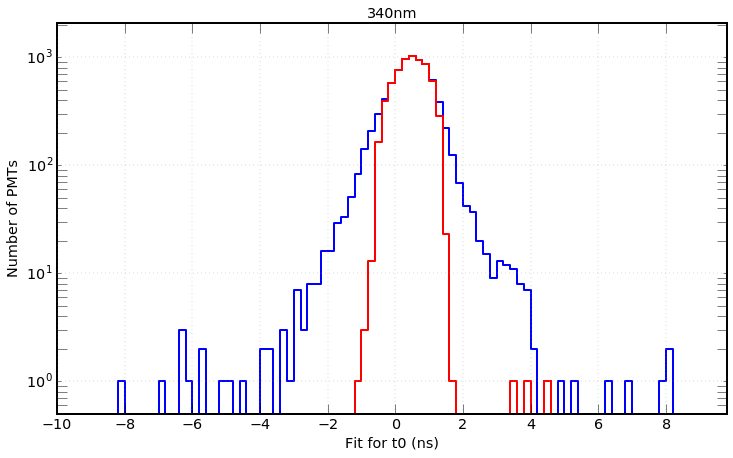

In [29]:
dist_ax = np.arange(-10, 10, 0.2)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)


b, x = np.histogram(fit['t0'][valid_fits], dist_ax)
b2, x = np.histogram(fit['t0'][valid_fits*valid_radius], dist_ax)

jplot.unfilledBar(x,b)
jplot.unfilledBar(x,b2, color='red')
plt.title(wlstr)

plt.yscale('log')
plt.xlabel('Fit for t0 (ns)')
plt.ylabel('Number of PMTs')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.))
plt.ylim([0.5, b.max()*2])
fig.savefig(outfile + "_TzeroHist.png", dpi=200)
fig.savefig(outfile + "_TzeroHist.pdf")

#print np.median(fit['t0'][valid_fits*valid_radius])
t0_mean = np.mean(fit['t0'][valid_fits*valid_radius])
print 'Mean ', t0_mean

Time offset fits
Applying conditions


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


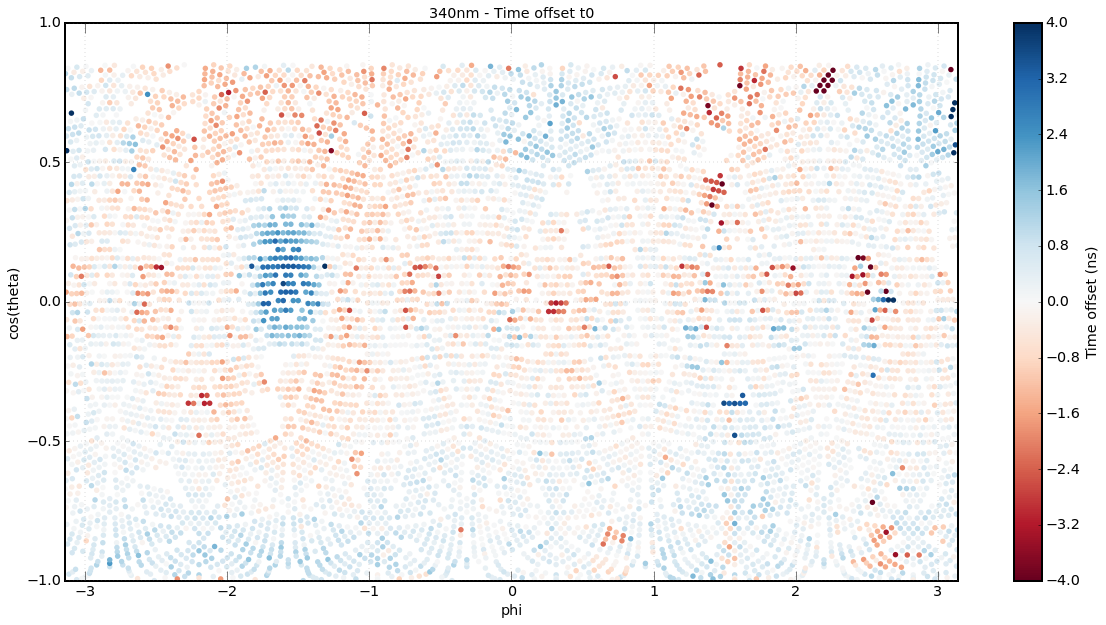

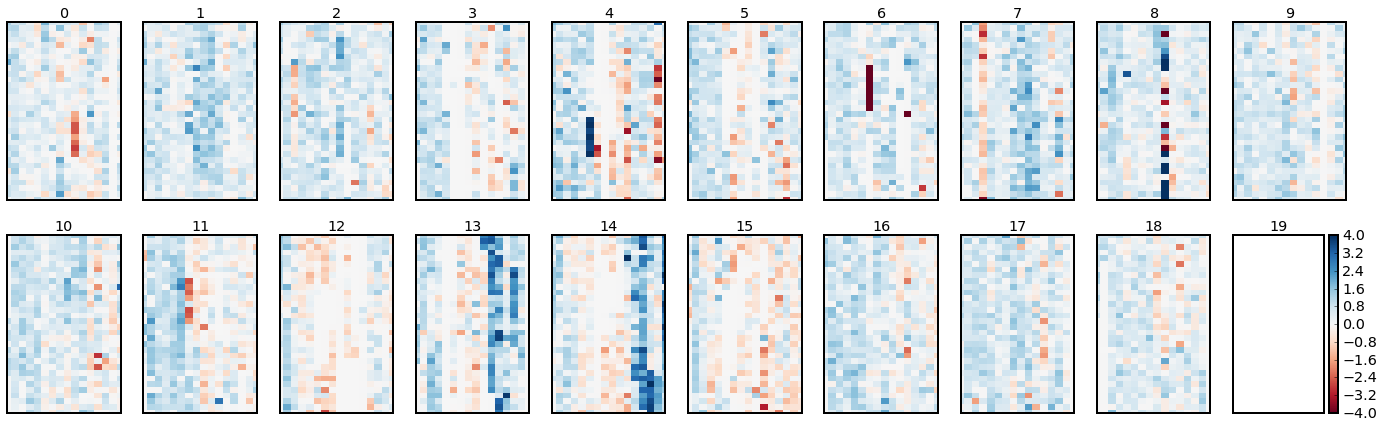

In [30]:
print 'Time offset fits'

vbounds = [-4, 4]

figsize = (20,10)
fig = plt.figure(figsize=figsize)
plt.scatter(pmt_info['phi'][valid_fits], pmt_info['costheta'][valid_fits],
           s= 30., c = fit['t0'][valid_fits]-t0_mean,
           edgecolor = '', vmin=vbounds[0], vmax=vbounds[1], cmap='RdBu')
plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.xlabel('phi')
plt.ylabel('cos(theta)')
plt.title(wlstr + ' - Time offset t0')
cb = plt.colorbar()
cb.ax.set_ylabel('Time offset (ns)')


fig = plotCCC(fit['t0'], valid_fits, 0.,  vmin=vbounds[0], vmax=vbounds[1], cmap='RdBu')
fig.savefig(outfile + "_TimeOffsetMap_ccc.png", dpi=200)
fig.savefig(outfile + "_TimeOffsetMap_ccc.pdf")

Time offset fits


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10
/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Applying conditions


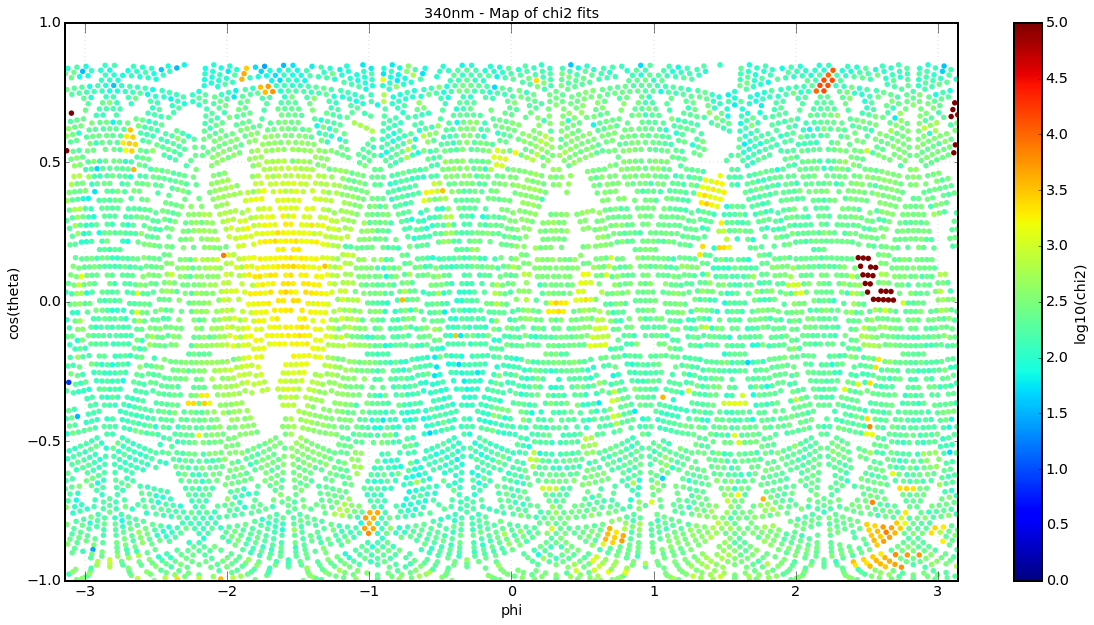

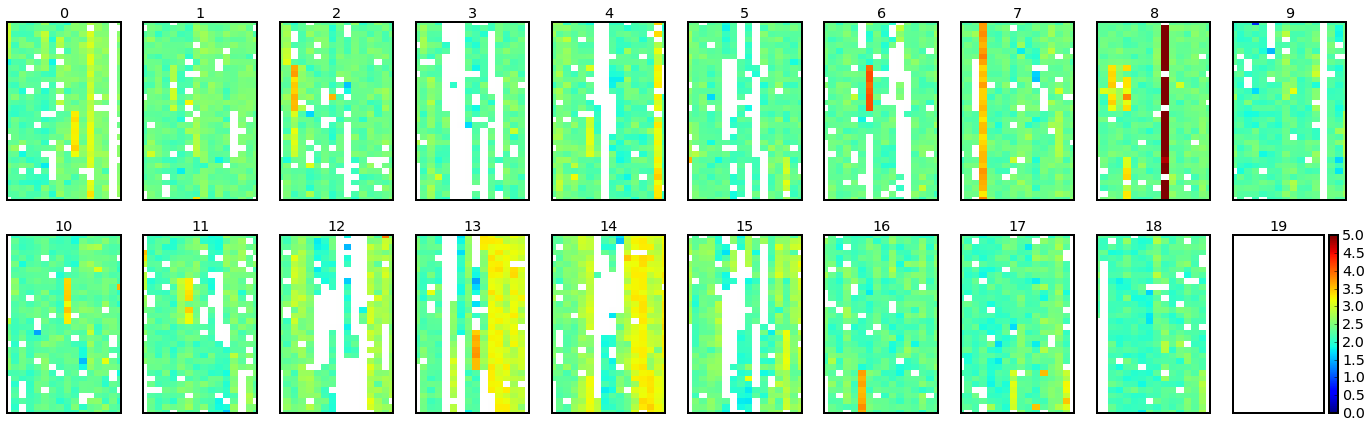

In [31]:
print 'Time offset fits'

vbounds = [0,5]
fig = plt.figure(figsize=figsize)
plt.scatter(pmt_info['phi'][valid_fits], pmt_info['costheta'][valid_fits],
           s= 30., c = np.log10(fit['chi2'][valid_fits]),
           edgecolor = '',  vmin=vbounds[0], vmax=vbounds[1], cmap='jet')
cb = plt.colorbar()
plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.xlabel('phi')
plt.ylabel('cos(theta)')
plt.title(wlstr + ' - Map of chi2 fits')
cb.ax.set_ylabel('log10(chi2)')
fig.savefig(outfile + "_Chi2Map.png", dpi=200)
fig.savefig(outfile + "_Chi2Map.pdf")

fig = plotCCC(np.log10(fit['chi2']), valid_fits,  vmin=vbounds[0], vmax=vbounds[1], cmap='jet')
fig.savefig(outfile + "_Chi2Map_ccc.png", dpi=200)
fig.savefig(outfile + "_Chi2Map_ccc.pdf")

(0.5, 126)

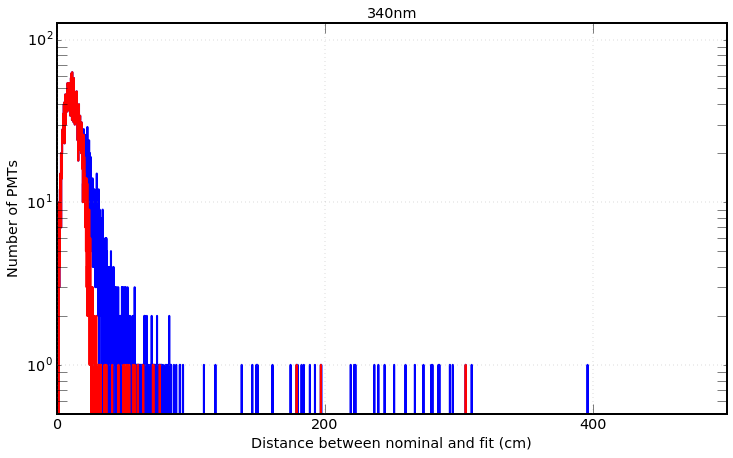

In [32]:
dist_ax = np.arange(0, 5000, 1)

ax = plt.figure(figsize=(12,7)).add_subplot(111)


b, x = np.histogram(fit['distance'][valid_fits], dist_ax)
b2, x = np.histogram(fit['distance'][valid_fits*valid_radius], dist_ax)

jplot.unfilledBar(x/10.,b)
jplot.unfilledBar(x/10.,b2, color='red')
plt.title(wlstr)

plt.yscale('log')
plt.xlabel('Distance between nominal and fit (cm)')
plt.ylabel('Number of PMTs')
ax.xaxis.set_major_locator(ticker.MultipleLocator(200.))
plt.ylim([0.5, b.max()*2])


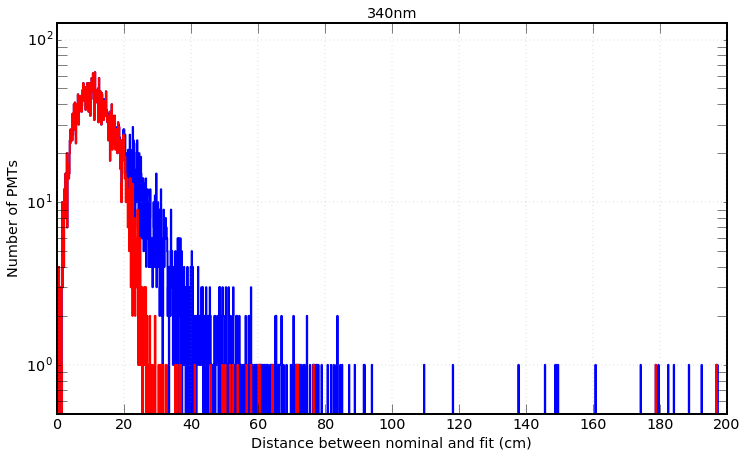

In [33]:
dist_ax = np.arange(0, 6000, 1)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)


b, x = np.histogram(fit['distance'][valid_fits], dist_ax)
b2, x = np.histogram(fit['distance'][valid_fits*valid_radius], dist_ax)

jplot.unfilledBar(x/10.,b)
jplot.unfilledBar(x/10.,b2, color='red')
plt.title(wlstr)



plt.yscale('log')
plt.xlabel('Distance between nominal and fit (cm)')
plt.ylabel('Number of PMTs')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20.))
plt.ylim([0.5, b.max()*2])
plt.xlim([0, 200])
fig.savefig(outfile + "_DistHist.png", dpi=200)
fig.savefig(outfile + "_DistHist.pdf")

/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/numpy-1.12.0-py2.7-linux-x86_64.egg/numpy/ma/core.py:6473: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


Max angle 20.8500304261


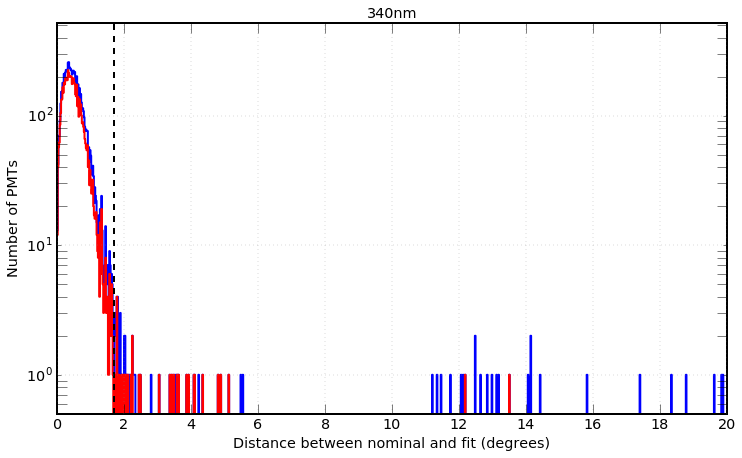

In [34]:
dist_ax = np.arange(0, 20, 0.02)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)


b, x = np.histogram(np.rad2deg(fit['angle'][valid_fits]), dist_ax)
b2, x = np.histogram(np.rad2deg(fit['angle'][valid_fits*valid_radius]), dist_ax)

jplot.unfilledBar(x,b)
jplot.unfilledBar(x,b2, color='red')
plt.title(wlstr)



plt.yscale('log')
plt.xlabel('Distance between nominal and fit (degrees)')
plt.ylabel('Number of PMTs')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.))

plt.axvline(x = np.rad2deg(angle_tol), ymin=0, ymax = b.max()*2, linestyle = '--', color = 'k')

plt.ylim([0.5, b.max()*2])
plt.xlim([0, 20])
fig.savefig(outfile + "_AngDistHist.png", dpi=200)
fig.savefig(outfile + "_AngDistHist.pdf")

print 'Max angle', np.rad2deg(fit['angle'][valid_fits].max())

Mean chi2 218.471628177


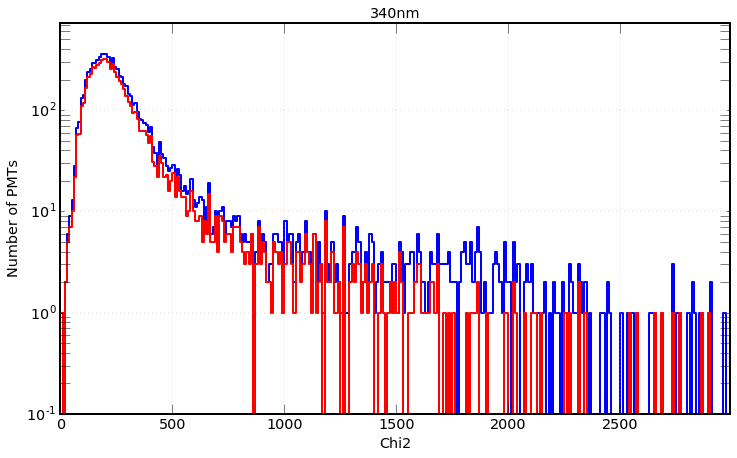

In [35]:
chi2_ax = np.arange(0, 3000, 10.)
ax_centers = (chi2_ax[1:] + chi2_ax[:-1])/2.

print 'Mean chi2', np.median(fit['chi2'][fit['distance']>0])

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
b, x = np.histogram(fit['chi2'][valid_fits], chi2_ax)
b2, x = np.histogram(fit['chi2'][valid_fits*valid_radius], chi2_ax)
plt.title(wlstr)

jplot.unfilledBar(x,b)
jplot.unfilledBar(x,b2,color='red')

'''
p, pcov = scipy.optimize.curve_fit(chi2, ax_centers, b, p0 = [b.max(),40])
pdf = chi2(chi2_ax, *p)
plt.plot(chi2_ax, pdf, '--k')
'''


#plt.xlim(0,3000)
plt.yscale('log')
plt.xlabel('Chi2')
plt.ylabel('Number of PMTs')
plt.ylim(0.1, b.max()*2)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20.))
fig.savefig(outfile + "_Chi2Hist.png", dpi=200)
fig.savefig(outfile + "_Chi2Hist.pdf")

In [36]:
print 'Setting critical values'

if wavelength == 420:
    chi2_cut = 400.
elif wavelength == 504:
    chi2_cut = 500.
elif wavelength == 392:
    chi2_cut = 500.
elif wavelength == 444:
    chi2_cut =500.
elif wavelength == 340:
    chi2_cut = 500.

'''
# Critical for 388
if wavelength == 388:
    chi2_cut = 800
elif wavelength == 340:
    chi2_cut= 500.
elif wavelength == 502 or wavelength == 420:
    chi2_cut = 400.
elif wavelength == 371:
    chi2_cut = 1000.
elif wavelength == 444 or wavelength == 502:
    chi2_cut = 600.
'''
print chi2_cut


bad_positions = fit['distance']>dist_tol
good_chi2  = fit['chi2']<chi2_cut



Setting critical values
500.0


1442


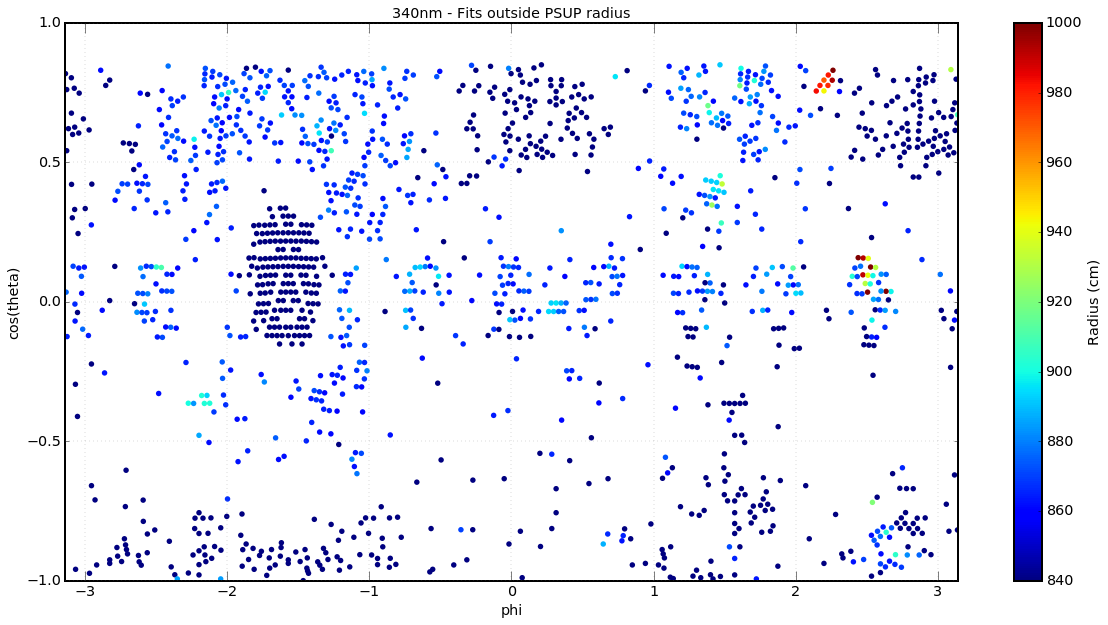

In [37]:
mybool2 = valid_fits*~valid_radius
print np.sum(mybool2)
vbounds = [840,1000]
figsize = (20,10)
fig = plt.figure(figsize=figsize)
plt.scatter(pmt_info['phi'][mybool2], pmt_info['costheta'][mybool2],
           s= 30., c = fit['radius'][mybool2]/10.,  vmin=vbounds[0], vmax=vbounds[1],
           edgecolor = '')
cb = plt.colorbar()
plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.xlabel('phi')
plt.ylabel('cos(theta)')
plt.title(wlstr + ' - Fits outside PSUP radius')
cb.ax.set_ylabel('Radius (cm)')
fig.savefig(outfile + "_OutsideFitsMap.png", dpi=200)
fig.savefig(outfile + "_OutsideFitsMap.pdf")

Bad fits (angular distance between fit and DB)
1442


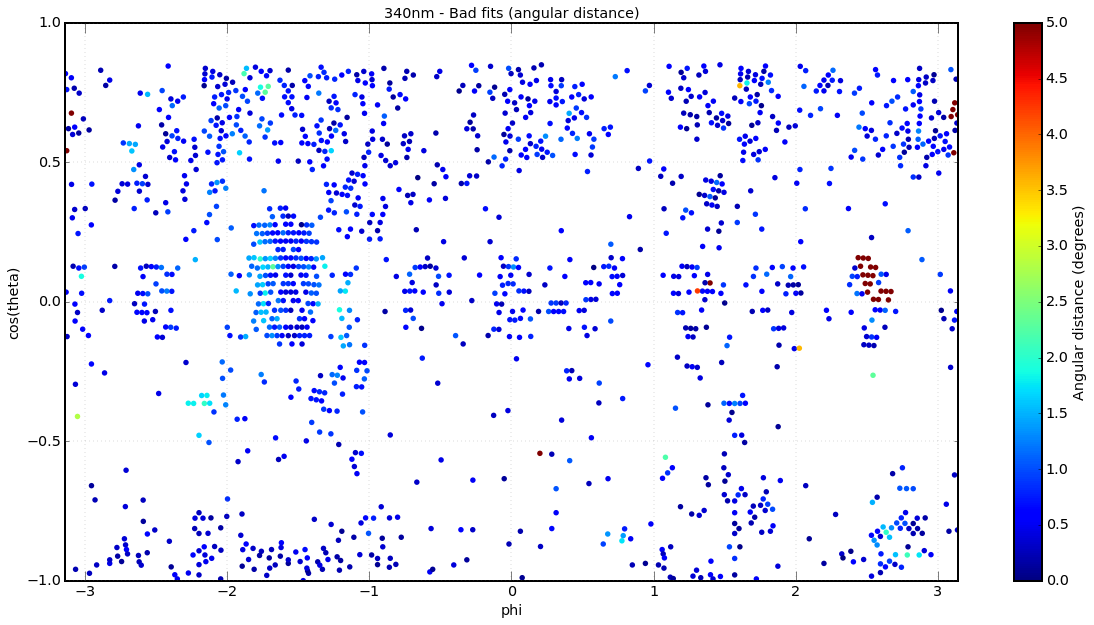

In [38]:
print 'Bad fits (angular distance between fit and DB)'


mybool2 = valid_fits*(~valid_radius)
print np.sum(mybool2)

vbounds = [0,5]
figsize = (20,10)
fig = plt.figure(figsize=figsize)
plt.scatter(pmt_info['phi'][mybool2], pmt_info['costheta'][mybool2],
           s= 30., c = np.rad2deg(fit['angle'][mybool2]),  vmin=vbounds[0], vmax=vbounds[1],
           edgecolor = '')

cb = plt.colorbar()
cb.ax.set_ylabel('Angular distance (degrees)')

plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.xlabel('phi')
plt.ylabel('cos(theta)')
plt.title(wlstr + ' - Bad fits (angular distance)')
fig.savefig(outfile + "_OutsideFitsMap2.png", dpi=200)
fig.savefig(outfile + "_OutsideFitsMap2.pdf")

Bad fits (angular distance between fit and DB)
55


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Applying conditions


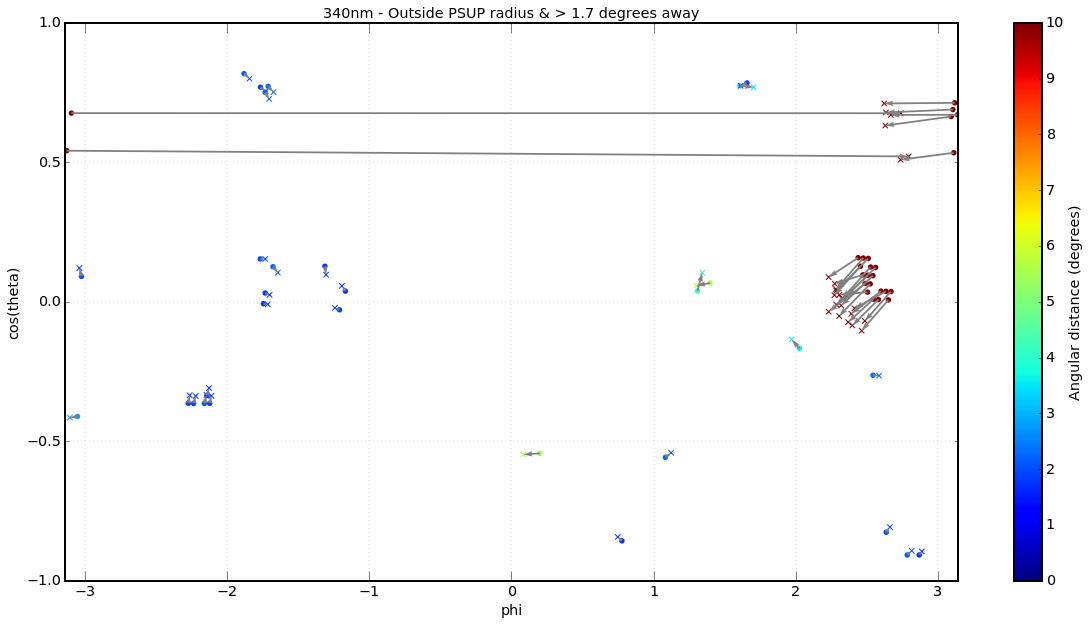

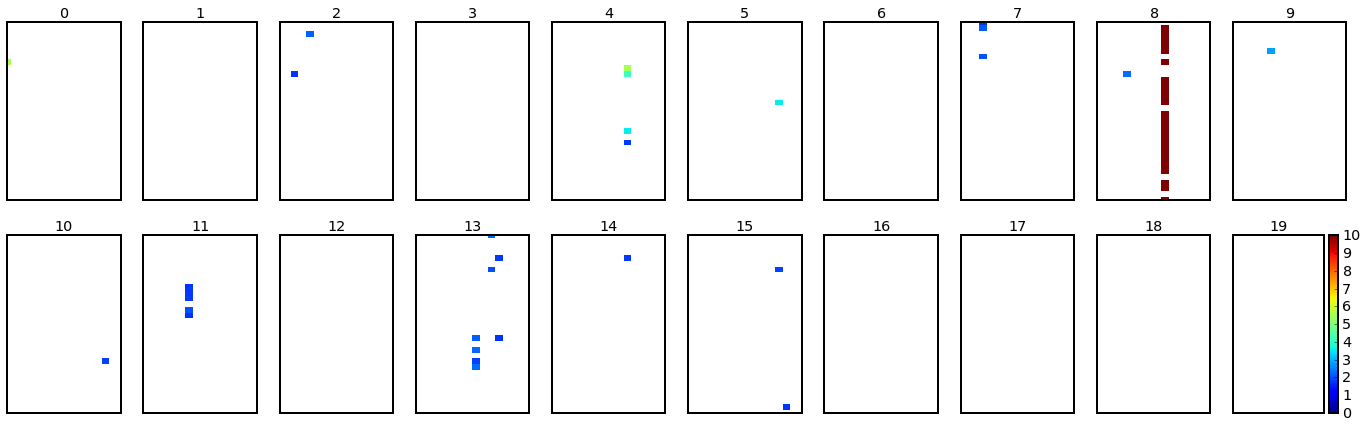

In [39]:
print 'Bad fits (angular distance between fit and DB)'

mybool2 = valid_fits*~valid_radius*(fit['angle']>angle_tol)
vbounds = [0,10]


print np.sum(mybool2)


figsize = (20,10)
fig = plt.figure(figsize=figsize)
plt.scatter(pmt_info['phi'][mybool2], pmt_info['costheta'][mybool2],
           s= 30., c = np.rad2deg(fit['angle'][mybool2]),  vmin=vbounds[0], vmax=vbounds[1],
           edgecolor = '')
plt.scatter(fit['phi'][mybool2], fit['costheta'][mybool2],
           s= 30., c = np.rad2deg(fit['angle'][mybool2]),  vmin=vbounds[0], vmax=vbounds[1], marker = 'x',
           edgecolor = '')
cb = plt.colorbar()
cb.ax.set_ylabel('Angular distance (degrees)')
plt.quiver(pmt_info['phi'][mybool2], pmt_info['costheta'][mybool2],
           (fit['phi']-pmt_info['phi'])[mybool2], (fit['costheta']-pmt_info['costheta'])[mybool2],
           angles='xy', scale_units='xy', scale=1, width=0.002, color = '0.5')
plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.xlabel('phi')
plt.ylabel('cos(theta)')
plt.title(wlstr + ' - Outside PSUP radius & > 1.7 degrees away')
fig.savefig(outfile + "_OutsideFitsMap2.png", dpi=200)
fig.savefig(outfile + "_OutsideFitsMap2.pdf")

fig = plotCCC(np.rad2deg(fit['angle']), mybool2,   vmin=vbounds[0], vmax=vbounds[1], cmap='jet')
fig.savefig(outfile + "_OutsideFitsMap2_ccc.png", dpi=200)
fig.savefig(outfile + "_OutsideFitsMap2_ccc.pdf")

Potentially mislabeled
PMTs that seem to be bad (all fits) 26


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


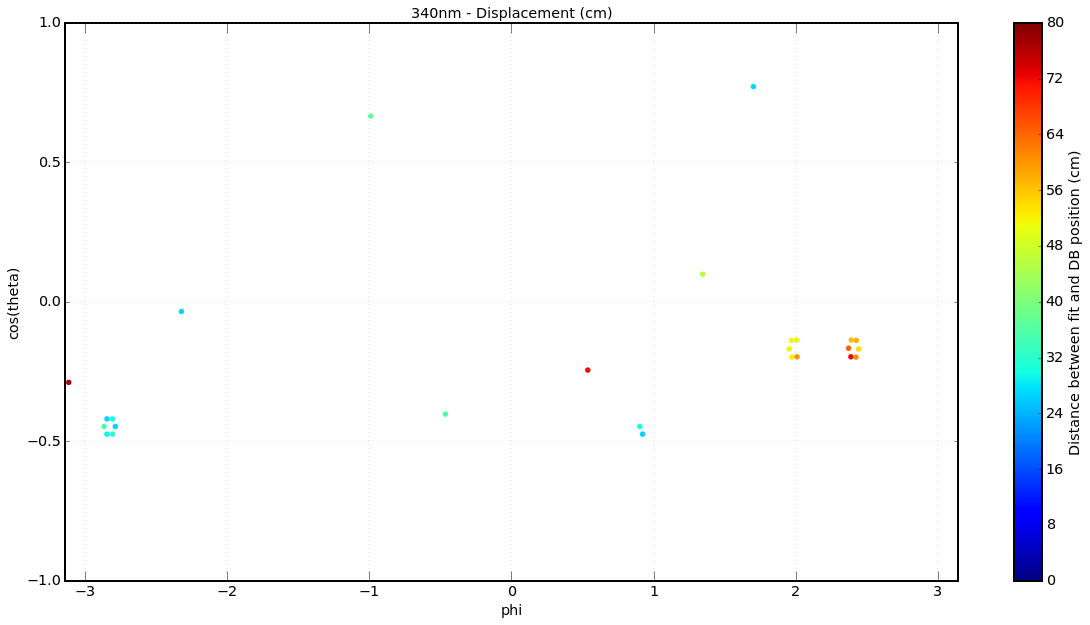

In [40]:
print 'Potentially mislabeled'
mybool = valid_fits*valid_radius*good_chi2*(fit['angle']>angle_tol)
print 'PMTs that seem to be bad (all fits)', np.sum(mybool)
figsize = (20,10)

vbounds = [0, 80]
fig = plt.figure(figsize=figsize)
plt.title(wlstr + ' - Displacement (cm)')

plt.scatter(pmt_info['phi'][mybool], pmt_info['costheta'][mybool],
           s= 30., c = fit['distance'][mybool]/10.,  vmin=vbounds[0], vmax=vbounds[1],
           edgecolor = '')




plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.ylabel('cos(theta)')
plt.xlabel('phi')
cb = plt.colorbar()
cb.ax.set_ylabel('Distance between fit and DB position (cm)')
fig.savefig(outfile + "_DisplacedMap.png", dpi=200)
fig.savefig(outfile + "_DisplacedMap.pdf")

Potentially mislabeled
PMTs that seem to be bad (all fits) 26


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Applying conditions


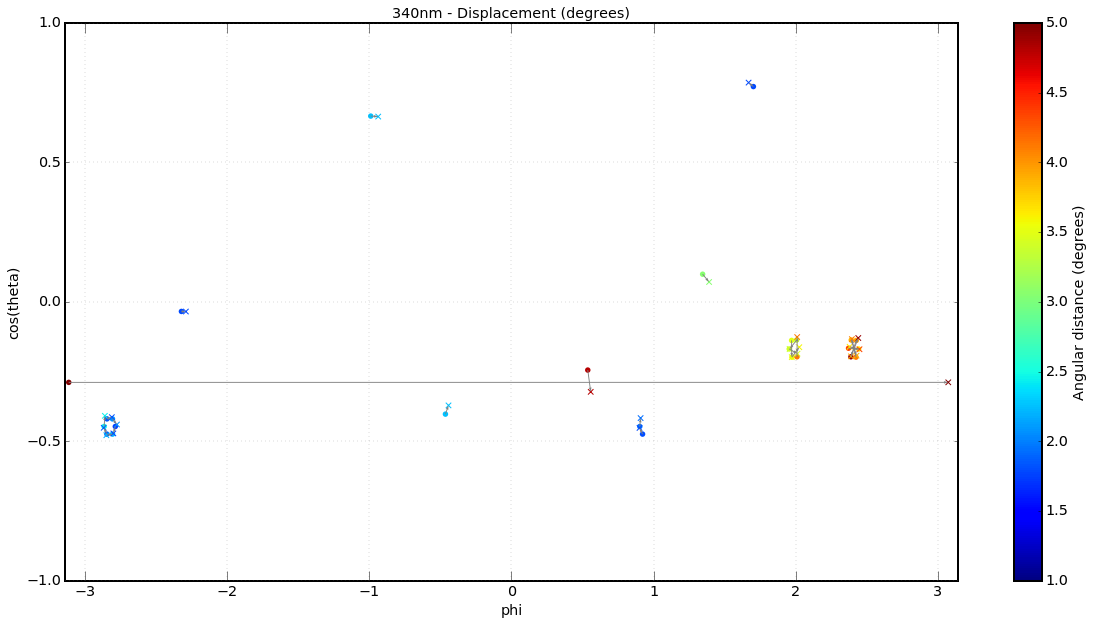

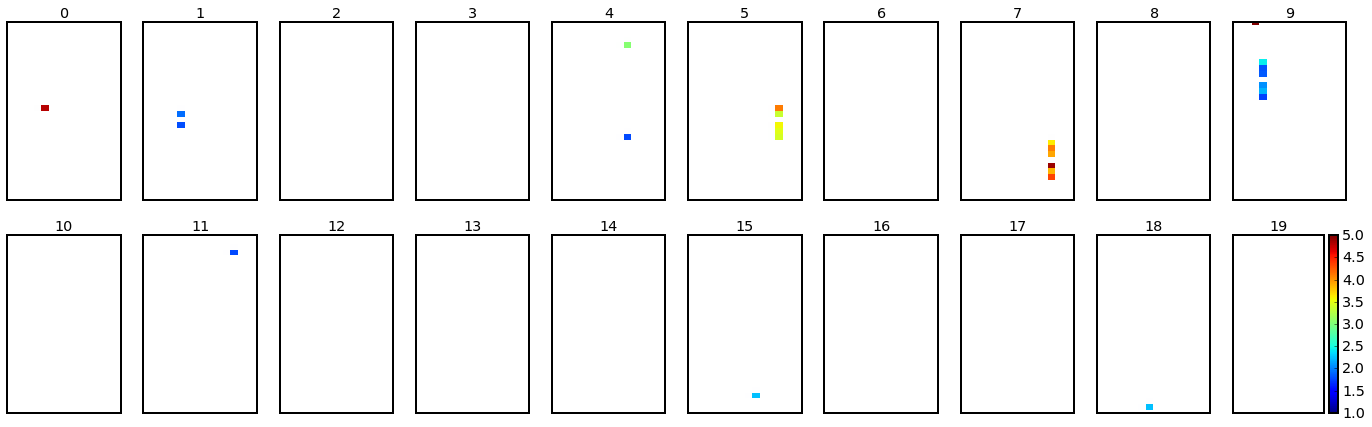

In [41]:
print 'Potentially mislabeled'
#mybool = valid_fits*bad_positions*valid_radius*good_chi2
print 'PMTs that seem to be bad (all fits)', np.sum(mybool)
figsize = (20,10)
fig = plt.figure(figsize=figsize)
plt.title(wlstr + ' - Displacement (degrees)')

size = 30
vbounds = [1.,5]
plt.scatter(pmt_info['phi'][mybool], pmt_info['costheta'][mybool],
           s= 30., c = np.rad2deg(fit['angle'][mybool]),  vmin=vbounds[0], vmax=vbounds[1],
           edgecolor = '')
plt.scatter(fit['phi'][mybool], fit['costheta'][mybool],
           s= 30., c = np.rad2deg(fit['angle'][mybool]),  vmin=vbounds[0], vmax=vbounds[1],
           edgecolor = 'k', marker = 'x')

cb = plt.colorbar()
cb.ax.set_ylabel('Angular distance (degrees)')
plt.quiver(pmt_info['phi'][mybool], pmt_info['costheta'][mybool],
           (fit['phi']-pmt_info['phi'])[mybool], (fit['costheta']-pmt_info['costheta'])[mybool],
           angles='xy', scale_units='xy', scale=1, width=0.001, color = '0.5')
center = [1.5,-0.]

#plt.xlim(center[0]-0.5, center[0]+0.5)
#plt.ylim(center[1]-0.1,center[1]+0.1)
plt.xlim(-np.pi, np.pi)
plt.ylim(-1,1)
plt.ylabel('cos(theta)')
plt.xlabel('phi')
fig.savefig(outfile + "_Displaced2.png", dpi=200)
fig.savefig(outfile + "_Displaced2.pdf")


fig = plotCCC(np.rad2deg(fit['angle']), mybool,   vmin=vbounds[0], vmax=vbounds[1], cmap='jet')
fig.savefig(outfile + "_Displaced2_ccc.png", dpi=200)
fig.savefig(outfile + "_Displaced2_ccc.pdf")

## Using the t0 to obtain laserball position correction ##


In [42]:
tzero_outfile = os.path.join(outdir, 'pmt_t0', filename.rstrip('.pckl'))

In [46]:
%%capture
# Not showing figures

valid_t0 = valid_fits*good_chi2
xarray = np.linspace(-1, 1, 500)
lb_displacement = np.zeros([len(all_runs['lb_wavelength']), 3])
lb_disp_errors  = np.zeros_like(lb_displacement)

for irun in range(len(all_runs['lb_wavelength'])):

    fig = plt.figure(figsize=(10,12))
    
    gvel = rat_misc.group_vel_fcn(all_runs['lb_wavelength'][irun])
    y = (fit['t0'][valid_t0])*gvel

    # Testing my t0 against all the runs
    pmt_dist = all_runs['lb_position'][irun] - pmt_info['xyz']
    pmt_totd = np.linalg.norm(pmt_dist, axis=1)

    ax1 = fig.add_subplot(3,1,1)
    x = pmt_dist[:,0][valid_t0]/pmt_totd[valid_t0]
    p, pcov = optimize.curve_fit(jp_analysis.line_fcn, x, y, p0=[100, 0.])
    perr = np.sqrt(np.diag(pcov))
    lb_displacement[irun,0] = p[0]
    lb_disp_errors[irun,0] = perr[0]
    plt.plot(x,y, '.', markersize=1)
    plt.plot(xarray, jp_analysis.line_fcn(xarray, *p), 'k')
    plt.ylabel('v_group * delta_t (mm)')
    plt.xlabel('x/tot dist')

    ax2 = fig.add_subplot(3,1,2, sharey=ax1, sharex=ax1)
    x = pmt_dist[:,1][valid_t0]/pmt_totd[valid_t0]
    p, pcov = optimize.curve_fit(jp_analysis.line_fcn, x, y, p0=[100, 0.])
    perr = np.sqrt(np.diag(pcov))
    lb_displacement[irun,1] = p[0]
    lb_disp_errors[irun,1] = perr[0]
    plt.plot(x,y, '.', markersize=1)
    plt.plot(xarray, jp_analysis.line_fcn(xarray, *p), 'k')    
    plt.ylabel('v_group * delta_t (mm)')
    plt.xlabel('y/tot dist')

    ax3 = fig.add_subplot(3,1,3, sharey=ax1, sharex =ax1)
    x = pmt_dist[:,2][valid_t0]/pmt_totd[valid_t0]
    p, pcov = optimize.curve_fit(jp_analysis.line_fcn, x, y, p0=[100, 0.])
    perr = np.sqrt(np.diag(pcov))
    lb_displacement[irun,2] = p[0]
    lb_disp_errors[irun,2] = perr[0]
    plt.plot(x,y, '.', markersize=1)
    plt.plot(xarray, jp_analysis.line_fcn(xarray, *p), 'k')    
    plt.ylabel('v_group * delta_t (mm)')
    plt.xlabel('z/tot dist')
    
    plt.ylim(-800, 800)
    #plt.ylim(-200,200)
    plt.xlim(-1,1)

    plt.subplots_adjust(hspace = 0.3)
    fig.savefig(tzero_outfile + "_t0fit_" + all_runs['lb_run'][irun] + ".png", dpi=100)


    


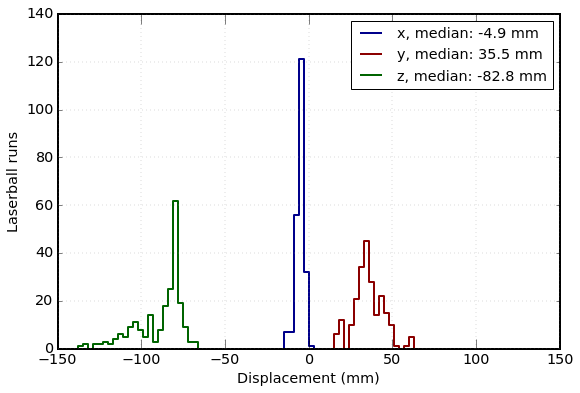

In [47]:
xaxis = np.linspace(-150., 150., 101)
bx, x = np.histogram(-lb_displacement[:,0], xaxis)
by, x = np.histogram(-lb_displacement[:,1], xaxis)
bz, x = np.histogram(-lb_displacement[:,2], xaxis)

medians = np.median(-lb_displacement,axis=0)

fig = plt.figure(figsize=(9,6))
jplot.unfilledBar(x, bx, color='darkblue', label ='x, median: ' + "%.1f" % medians[0] + ' mm')
jplot.unfilledBar(x, by, color='darkred', label ='y, median: ' + "%.1f" % medians[1] + ' mm')
jplot.unfilledBar(x, bz, color='darkgreen', label ='z, median: ' + "%.1f" % medians[2] + ' mm')
plt.legend(loc=0)
plt.xlabel('Displacement (mm)')
plt.ylabel('Laserball runs')
fig.savefig(outfile + "_t0_displacement.png", dpi=200)
fig.savefig(outfile + "_t0_displacement.pdf")
